In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import reedsolo as rs

In [2]:
def plot_all_images(images):
    fig, axes = plt.subplots(3, 6, figsize=(20, 8))
    for i, (filename, image) in enumerate(images):
        row = i // 6
        col = i % 6
        axes[row, col].axis("off")
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].set_title(filename, fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

In [3]:
images = pickle.load(open("read_images.pkl", "rb"))

In [4]:
# plot_all_images(images)

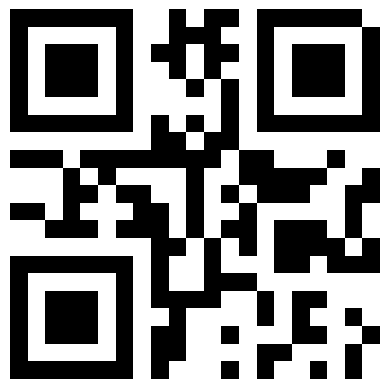

In [12]:
image = images[4][1]

plot_image(image)

In [6]:
# image

In [7]:
std_numeric_img = np.where(image == 0, 1, 0)

In [8]:
std_numeric_img

array([[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,

In [9]:
error_correction_level = std_numeric_img[8, 0:2]
_error_correction_level = std_numeric_img[-2:, 8][::-1]

assert np.all(
    error_correction_level == _error_correction_level
), "Error correction level not consistent"

error_correction_level = error_correction_level.tolist()

error_correction_level

AssertionError: Error correction level not consistent

In [ ]:
mask_pattern = std_numeric_img[8, 2:5]
_mask_pattern = std_numeric_img[-5:-2, 8][::-1]

assert np.all(mask_pattern == _mask_pattern), "Mask pattern not consistent"

mask_pattern = mask_pattern.tolist()

mask_str = "".join([str(x) for x in mask_pattern])

mask_str

'110'

In [ ]:
format_error_correction = []
format_error_correction.append(std_numeric_img[8, 5])
format_error_correction.append(std_numeric_img[8, 7])
format_error_correction.extend(std_numeric_img[0:6, 8])
format_error_correction.extend(std_numeric_img[7:9, 8])
len(format_error_correction)

10

In [ ]:
error_correction_level, mask_pattern, format_error_correction

([1, 1], [1, 1, 0], [0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
error_correction_level[0] ^= 1
mask_pattern[0] ^= 1
mask_pattern[2] ^= 1
format_error_correction[5] ^= 1
format_error_correction[8] ^= 1

In [ ]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

In [ ]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"


def apply_mask(data_start_i, data_start_j, direction, image):
    """
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    """
    result = []
    row_offsets = []
    col_offsets = []
    if direction in [UP, UP_ENC]:
        row_offsets = [0, 0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
    if direction == DOWN:
        row_offsets = [0, 0, 1, 1, 2, 2, 3, 3]
        col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
    if direction == CW:
        row_offsets = [0, 0, 1, 1, 1, 1, 0, 0]
        col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]
    if direction == CCW:
        row_offsets = [0, 0, -1, -1, -1, -1, 0, 0]
        col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = image[data_start_i + i, data_start_j + j]
        result.append(
            int(
                cell
                if MASKS[mask_str](data_start_i + i, data_start_j + j)
                else not cell
            )
        )

    return result[:4] if direction == UP_ENC else result

In [ ]:
grid_cells_num = len(image)

In [ ]:
def get_enc_and_len_bits(image):
    enc_bits = apply_mask(grid_cells_num - 1, grid_cells_num - 1, UP_ENC, image)
    len_bits = apply_mask(grid_cells_num - 3, grid_cells_num - 1, UP, image)

    return enc_bits, len_bits

In [ ]:
enc_bits, len_bits = get_enc_and_len_bits(image)

print(f"{enc_bits} = Byte encoding (8 bits per character)")

print(
    f"{len_bits} = {int(''.join([str(bit) for bit in len_bits]), 2)} data symbols, each consisting of 8 bits"
)

[0, 1, 0, 0] = Byte encoding (8 bits per character)
[0, 1, 0, 0, 0, 0, 0, 1] = 65 data symbols, each consisting of 8 bits


In [ ]:
data_starting_indices = [
    [grid_cells_num - 7, grid_cells_num - 1, UP],  #    w    /     H
    [grid_cells_num - 11, grid_cells_num - 1, CCW],  #    w    /     e
    [grid_cells_num - 10, grid_cells_num - 3, DOWN],  #    w    /     l
    [grid_cells_num - 6, grid_cells_num - 3, DOWN],  #    .    /     l
    [grid_cells_num - 2, grid_cells_num - 3, CW],  #    w    /     o
    [grid_cells_num - 3, grid_cells_num - 5, UP],  #    i    /     ,
    [grid_cells_num - 7, grid_cells_num - 5, UP],  #    k    /  (space)
    [grid_cells_num - 11, grid_cells_num - 5, CCW],  #    i    /     Q
    [grid_cells_num - 10, grid_cells_num - 7, DOWN],  #    p    /     R
    [grid_cells_num - 6, grid_cells_num - 7, DOWN],  #    e    /  (space)
    [grid_cells_num - 2, grid_cells_num - 7, CW],  #    d    /     W
    [grid_cells_num - 3, grid_cells_num - 9, UP],  #    i    /     o
    [grid_cells_num - 7, grid_cells_num - 9, UP],  #    a    /     r
    [grid_cells_num - 11, grid_cells_num - 9, UP],  #    .    /     l
    [grid_cells_num - 16, grid_cells_num - 9, UP],  #    o    /     d
    [grid_cells_num - 20, grid_cells_num - 9, CCW],  #    r    /     !
    [grid_cells_num - 19, grid_cells_num - 11, DOWN],  #    g    /     1
    [grid_cells_num - 14, grid_cells_num - 11, DOWN],  # End of message (Terminator)
    [grid_cells_num - 12, grid_cells_num - 11, DOWN],  # E1
    [grid_cells_num - 8, grid_cells_num - 11, DOWN],  # E2
    [grid_cells_num - 4, grid_cells_num - 11, DOWN],  # E3
    [grid_cells_num - 9, grid_cells_num - 13, UP],  # E4
    [grid_cells_num - 12, grid_cells_num - 16, DOWN],  # E5
    [grid_cells_num - 9, grid_cells_num - 18, UP],  # E6
    [grid_cells_num - 12, grid_cells_num - 20, DOWN],  # E7
]